Dataset: https://mesonet.agron.iastate.edu/request/download.phtml?network=NY_ASOS

### Importing libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns
from scipy.stats import spearmanr, boxcox
from collections import Counter
from datetime import datetime
from sklearn.preprocessing import KBinsDiscretizer

### Loading data

In [2]:
path = "/Users/afnan/Desktop/python/Data_science_Notes/Uber_data"

In [3]:
weather = pd.read_csv(f"{path}/dataset/new_york_weather.csv")

In [4]:
weather.head(3)

,Unnamed: 0,valid,tmpf,dwpf,relh,drct,sknt,p01i,alti,mslp,...,skyl2,skyl3,skyl4,wxcodes,peak_wind_gust,peak_wind_drct,peak_wind_time,feel,metar,snowdepth
0,0,2021-01-01 00:51,40.0,26.1,57.47,320.0,13.0,0.0,30.34,1027.4,...,15000.0,NaN,NaN,NaN,NaN,NaN,NaN,31.69,KJFK 010051Z 32013KT 10SM FEW030 OVC150 04/M03...,NaN
1,1,2021-01-01 01:51,39.0,24.1,54.77,350.0,9.0,0.0,30.35,1027.8,...,17000.0,NaN,NaN,NaN,NaN,NaN,NaN,32.22,KJFK 010151Z 35009KT 10SM FEW030 SCT170 04/M04...,NaN
2,2,2021-01-01 02:51,36.0,24.1,61.62,340.0,7.0,0.0,30.38,1028.8,...,25000.0,NaN,NaN,NaN,NaN,NaN,NaN,29.65,KJFK 010251Z 34007KT 10SM FEW160 FEW250 02/M04...,NaN


In [5]:
weather.shape

(9704, 27)

In [6]:
weather.columns

Index(['Unnamed: 0', 'valid', 'tmpf', 'dwpf', 'relh', 'drct', 'sknt', 'p01i',
       'alti', 'mslp', 'vsby', 'gust', 'skyc1', 'skyc2', 'skyc3', 'skyc4',
       'skyl1', 'skyl2', 'skyl3', 'skyl4', 'wxcodes', 'peak_wind_gust',
       'peak_wind_drct', 'peak_wind_time', 'feel', 'metar', 'snowdepth'],
      dtype='object')

# 1. Data cleaning

In [7]:
weather.dtypes

Unnamed: 0          int64
valid              object
tmpf              float64
dwpf              float64
relh              float64
drct              float64
sknt              float64
p01i              float64
alti              float64
mslp              float64
vsby              float64
gust              float64
skyc1              object
skyc2              object
skyc3              object
skyc4              object
skyl1             float64
skyl2             float64
skyl3             float64
skyl4             float64
wxcodes            object
peak_wind_gust    float64
peak_wind_drct    float64
peak_wind_time     object
feel              float64
metar              object
snowdepth         float64
dtype: object

## 1.1 Timestamp data cleaning

In [8]:
# Transforming timestamp data

In [9]:
weather = weather.rename(columns= {'valid': 'timestamp'})
weather['timestamp'] = pd.to_datetime(weather['timestamp'])

In [10]:
weather['date'] = weather['timestamp'].dt.date
weather['hour'] = weather['timestamp'].dt.hour
weather['month'] = weather['timestamp'].dt.month

In [11]:
print("Min: ", weather['timestamp'].min())
print("Max: ", weather['timestamp'].max())

Min:  2021-01-01 00:51:00
Max:  2021-12-31 23:51:00


In [12]:
weather.shape

(9704, 30)

There are 365 days in 2021 and 24 hours in each day. 

365 x 24 = 8760

In [13]:
weather = weather.drop_duplicates(subset=['date', 'hour'], keep='last')

In [14]:
weather.shape

(8756, 30)

4 values are missing

In [15]:
weather['date'].value_counts()

date
2021-01-01    24
2021-09-09    24
2021-09-06    24
2021-09-05    24
2021-09-04    24
              ..
2021-04-27    24
2021-09-07    23
2021-03-20    23
2021-03-30    23
2021-01-26    23
Name: count, Length: 365, dtype: int64

In [16]:
def find_missing_hour(date):
    df = weather[weather['date'] == datetime.strptime(date, "%Y-%m-%d").date()]['hour']
    for i,h in zip(df, range(24)):
        if i!=h:
            return (f"{date}: {h}")

In [17]:
print(find_missing_hour('2021-09-07'))
print(find_missing_hour('2021-03-20'))
print(find_missing_hour('2021-03-30'))
print(find_missing_hour('2021-01-26'))

2021-09-07: 14
2021-03-20: 6
2021-03-30: 4
2021-01-26: 3


replacing missing hours with previous hour data

In [18]:
missing_hours = [('2021-09-07', '14'), ('2021-03-20', '6'), ('2021-03-30', '4'), ('2021-01-26','3')]

In [19]:
for value in missing_hours:
    df2 = weather[(weather['date'] == datetime.strptime(value[0], "%Y-%m-%d").date()) &
                    (weather['hour']==int(value[1])-1)]
    df2['hour'] = df2['hour'].replace(int(value[1])-1, value[1])
    weather = pd.concat([weather, df2])

/var/folders/m7/67q29b3s6rd557f6xm37t3m00000gn/T/ipykernel_83006/1568892475.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['hour'] = df2['hour'].replace(int(value[1])-1, value[1])


In [20]:
weather['hour'] = weather['hour'].astype(int)

In [21]:
weather.shape

(8760, 30)

In [22]:
weather = weather.sort_values(by='timestamp', ignore_index=True)

## 1.2 Object data cleaning

In [23]:
obj_cols = weather.select_dtypes('object').columns

In [24]:
weather[obj_cols].isnull().sum()

skyc1                1
skyc2             3381
skyc3             6330
skyc4             8152
wxcodes           7721
peak_wind_time    7862
metar                0
date                 0
dtype: int64

In [25]:
for col in obj_cols:
    print(weather[col].value_counts())

skyc1
FEW    4266
BKN    1657
SCT    1503
OVC     845
CLR     449
VV       39
Name: count, dtype: int64
skyc2
BKN    2256
SCT    1312
FEW     940
OVC     871
Name: count, dtype: int64
skyc3
BKN    1347
OVC     628
SCT     376
FEW      79
Name: count, dtype: int64
skyc4
BKN    450
OVC    120
SCT     37
FEW      1
Name: count, dtype: int64
wxcodes
-RA              309
BR               198
-RA BR           141
RA BR             63
-DZ BR            58
-SN BR            50
-SN               37
HZ                29
FG                24
-TSRA             17
-FZDZ BR          13
+RA BR            12
RA                10
TS                 6
-SNPL BLSN BR      5
VCTS               4
TSRA BR            4
SN FG              4
-RA FG             4
-FZDZ              4
-RASN              4
-SNRA BR           3
-TSRA BR           3
+TSRA BR           3
-DZ                3
SN BLSN FZFG       2
-FZRA BR           2
+RA                2
MIFG               2
-FZRA              2
-SN BLSN BR        2
V

### 1.2.1 Dropping columns

metar column contains the row information in metar format

Unnamed: 0 is an irrelevant column

In [26]:
weather = weather.drop(columns=['metar', 'Unnamed: 0'])

### 1.2.2 Renaming columns and changing data type

In [27]:
weather = weather.rename(columns= {'wxcodes': 'weather_codes'})

### 1.2.3 Handling null values

**'skyc1', 'skyc2', 'skyc3', 'skyc4'**

In [28]:
weather = weather.sort_values('timestamp')

In [29]:
# filling null values with previous sky coverage state. Limit = 3
weather[['skyc1', 'skyc2', 'skyc3', 'skyc4']] = weather[['skyc1', 'skyc2', 'skyc3', 'skyc4']].fillna(method='ffill', limit=3)

In [30]:
# filling remaining null values with next sky coverage state. Limit = 2
weather[['skyc1', 'skyc2', 'skyc3', 'skyc4']] = weather[['skyc1', 'skyc2', 'skyc3', 'skyc4']].fillna(method='bfill', limit=2)

**peak_wind_time**

Since we already have timestamp there is no need to have it for peak_wind_time

In [31]:
weather['peak_wind_time'] = weather['peak_wind_time'].notnull().astype(int)

In [32]:
weather['peak_wind_time'].value_counts()

peak_wind_time
0    7862
1     898
Name: count, dtype: int64

**weather_codes**

In [33]:
weather['weather_codes'] = weather['weather_codes'].fillna(method='ffill', limit = 1).fillna(method='bfill', limit=1)

**Checking results**

In [34]:
weather[['skyc1', 'skyc2', 'skyc3', 'skyc4', 'peak_wind_time', 'weather_codes']].isnull().sum()

skyc1                0
skyc2             1483
skyc3             4092
skyc4             7037
peak_wind_time       0
weather_codes     7232
dtype: int64

weather codes don't have clear sky as one of the codes. therefore replacing null values with CLR

In [35]:
weather['weather_codes'] = weather['weather_codes'].fillna('CLR')

For skyc2 and skyc3 finding spearman correlation. skyc4 will be dropped.

In [36]:
weather = weather.drop(columns='skyc4')

CLR (Clear): No clouds, clear sky.

FEW (Few clouds): Small portion of the sky covered by clouds.

SCT (Scattered clouds): Clouds dispersed, covering a portion of the sky.

BKN (Broken clouds): Significant cloud cover with breaks or open spaces.

OVC (Overcast): Entire sky covered with clouds, no breaks.

VV (Vertical visibility): Indicates the height of the cloud base, not directly comparable to the others.

In [37]:
ranks = {'CLR': 1, 'FEW': 2, 'SCT': 3, 'BKN': 4, 'OVC': 5, 'VV ': 6}

In [38]:
skyc = weather[['skyc1', 'skyc2', 'skyc3']].dropna().replace(ranks)

In [39]:
skyc['skyc1'].value_counts()

skyc1
2    2434
4    1013
3     931
5     259
6      16
1      15
Name: count, dtype: int64

In [40]:
correlation, p_value = spearmanr(skyc['skyc1'], skyc['skyc2'])

print(f"Spearman correlation coefficient: {correlation}")
print(f"P-value: {p_value}")

Spearman correlation coefficient: 0.5070310637718476
P-value: 1.85892898203117e-303


In [41]:
correlation, p_value = spearmanr(skyc['skyc1'], skyc['skyc3'])

print(f"Spearman correlation coefficient: {correlation}")
print(f"P-value: {p_value}")

Spearman correlation coefficient: 0.3472791755739815
P-value: 2.041025029102612e-132


In [42]:
correlation, p_value = spearmanr(skyc['skyc2'], skyc['skyc3'])

print(f"Spearman correlation coefficient: {correlation}")
print(f"P-value: {p_value}")

Spearman correlation coefficient: 0.5841902428087236
P-value: 0.0


## 1.3 Numeric data cleaning

In [43]:
float_cols = weather.select_dtypes('float64').columns

In [44]:
len(float_cols)

18

In [45]:
weather[float_cols].isnull().sum()

tmpf                 0
dwpf                 0
relh                 0
drct                62
sknt                 1
p01i               567
alti                 0
mslp                46
vsby                 1
gust              7555
skyl1              450
skyl2             3381
skyl3             6330
skyl4             8152
peak_wind_gust    7862
peak_wind_drct    7862
feel                 0
snowdepth         8666
dtype: int64

### 1.3.1 Dropping columns

In [46]:
# Highly correlated columns
def correlation(dataset, threshold):
    col_corr = set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]
                colname2 = corr_matrix.columns[j]
                col_corr. add (colname)
                col_corr. add (colname2)
                
    return col_corr

In [47]:
corr_cols = correlation(weather[float_cols], 0.8)

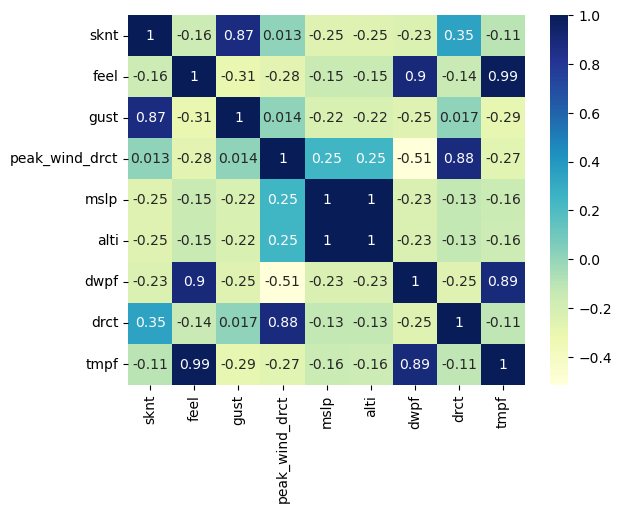

In [48]:
dataplot = sns.heatmap(weather[list(corr_cols)].corr(), cmap="YlGnBu", annot=True) 
plt.show() 

Removing highly correlated columns and keeping columns with less missing values

In [49]:
weather = weather.drop(columns=['peak_wind_drct', 'dwpf', 'dwpf', 'tmpf', 'gust', 'mslp'])

### 1.3.2 Renaming columns

Renaming columns for better understanding

In [50]:
weather.select_dtypes('float64').columns

Index(['relh', 'drct', 'sknt', 'p01i', 'alti', 'vsby', 'skyl1', 'skyl2',
       'skyl3', 'skyl4', 'peak_wind_gust', 'feel', 'snowdepth'],
      dtype='object')

**relh**: Relative Humidity in %

**drct**: Wind Direction in degrees from *true* north

**sknt**: Wind Speed in knots

**p01i**: One hour precipitation rate

**alti**: Pressure altimeter in inches

**vsby**: Visibility in miles

In [51]:
rename_cols = {'relh': 'humidity', 'drct': 'wind_direction', 'sknt': 'wind_speed', 'p01i': 'precipitation', 
               'alti': 'pressure', 'vsby': 'visibility'}

In [52]:
weather = weather.rename(columns=rename_cols)

### 1.3.3 Handling missing values

In [53]:
# columns with low missing values
low_miss_col = ['wind_direction', 'wind_speed', 'visibility']

In [54]:
weather[low_miss_col] = weather[low_miss_col].fillna(method='ffill')

In [55]:
# Sky altitudes

In [56]:
weather[['skyl1', 'skyl2', 'skyl3', 'skyl4']].isnull().sum()

skyl1     450
skyl2    3381
skyl3    6330
skyl4    8152
dtype: int64

In [57]:
weather = weather.drop(columns='skyl4')

In [58]:
weather['skyl1'] = weather['skyl1'].fillna(method='ffill', limit = 2).fillna(method='bfill', limit=2)
weather['skyl2'] = weather['skyl2'].fillna(method='ffill', limit = 2).fillna(method='bfill', limit=2)
weather['skyl3'] = weather['skyl3'].fillna(method='ffill', limit = 2).fillna(method='bfill', limit=2)

In [59]:
sky = weather[['skyl1', 'skyl2', 'skyl3']]

In [60]:
sky['avg_skyl'] = sky[['skyl1', 'skyl2', 'skyl3']].mean(axis=1)

/var/folders/m7/67q29b3s6rd557f6xm37t3m00000gn/T/ipykernel_83006/799339051.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sky['avg_skyl'] = sky[['skyl1', 'skyl2', 'skyl3']].mean(axis=1)


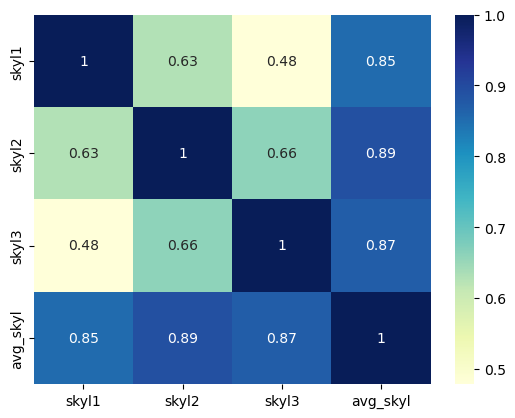

In [61]:
dataplot = sns.heatmap(sky.corr(), cmap="YlGnBu", annot=True) 
plt.show()

 Combining and taking average of sky level altitude

In [62]:
weather['avg_skyl'] = weather[['skyl1', 'skyl2', 'skyl3']].mean(axis=1)
weather = weather.drop(columns=['skyl1', 'skyl2', 'skyl3'])

In [63]:
float_cols = weather.select_dtypes('float64').columns

In [64]:
# checking for any other high correlated variables
correlation(weather[float_cols], 0.7)

set()

In [65]:
weather[float_cols].isnull().sum()

humidity             0
wind_direction       0
wind_speed           0
precipitation      567
pressure             0
visibility           0
peak_wind_gust    7862
feel                 0
snowdepth         8666
avg_skyl           174
dtype: int64

In [66]:
weather[['precipitation', 'peak_wind_gust', 'snowdepth', 'avg_skyl']].describe()

,precipitation,peak_wind_gust,snowdepth,avg_skyl
count,8193.000000,898.000000,94.000000,8586.000000
mean,0.004995,30.364143,6.787234,12594.871496
std,0.032845,4.266214,3.441906,7731.362204
min,0.000000,26.000000,1.000000,100.000000
25%,0.000000,27.000000,4.250000,5500.000000
50%,0.000000,29.000000,7.000000,12566.666667
75%,0.000000,32.000000,9.000000,18500.000000
max,0.860000,48.000000,13.000000,31333.333333


**snowdepth** has min value of 1 which indicates that all null values are 0. i.e there was no snow.

In [67]:
weather['snowdepth'] = weather['snowdepth'].fillna(0)

**peak_wind_gust** : According to the National Weather Service (NWS), in U.S., a gust of wind last less than 20 seconds. Such a short duration is not very effective parameter as a feature for our ML. Also we already have wind speed parameter which has no null values and takes average speed for the entire hour.

In [68]:
weather = weather.drop(columns='peak_wind_gust')
weather = weather.drop(columns='peak_wind_time')

**precipitation**: Filling missing values with previous hour values and others with zero

In [69]:
weather['precipitation'] = weather['precipitation'].fillna(method='ffill', limit = 1)

In [70]:
weather['precipitation'] = weather['precipitation'].fillna(0)

**avg_skyl**: filling remaining values with average values

In [71]:
weather['avg_skyl'] = weather['avg_skyl'].fillna(weather['avg_skyl'].mean())

# 2. Univariate analysis

## 2.1 Numeric data

In [72]:
float_cols = weather.select_dtypes('float64').columns

### 2.1.1 Central tendency

In [73]:
weather[float_cols].describe()

,humidity,wind_direction,wind_speed,precipitation,pressure,visibility,feel,snowdepth,avg_skyl
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,66.944371,202.536530,9.715297,0.005426,30.030194,9.402384,53.528398,0.072831,12594.871496
std,19.752518,107.679145,5.095166,0.034087,0.212245,1.927149,20.252737,0.784128,7654.184147
min,9.900000,0.000000,0.000000,0.000000,29.340000,0.000000,-2.020000,0.000000,100.000000
25%,51.802500,130.000000,6.000000,0.000000,29.890000,10.000000,36.190000,0.000000,5662.500000
50%,68.700000,210.000000,9.000000,0.000000,30.030000,10.000000,55.900000,0.000000,12594.871496
75%,83.990000,300.000000,13.000000,0.000000,30.180000,10.000000,71.100000,0.000000,18500.000000
max,100.000000,360.000000,33.000000,0.860000,30.670000,10.000000,100.710000,13.000000,31333.333333


In [74]:
num_plots = len(float_cols)

### 2.1.2 Skewness and kde plot

In [75]:
weather[float_cols].skew()

humidity          -0.327575
wind_direction    -0.391008
wind_speed         0.668742
precipitation     12.379303
pressure          -0.073493
visibility        -3.470496
feel              -0.255507
snowdepth         11.868804
avg_skyl           0.192821
dtype: float64

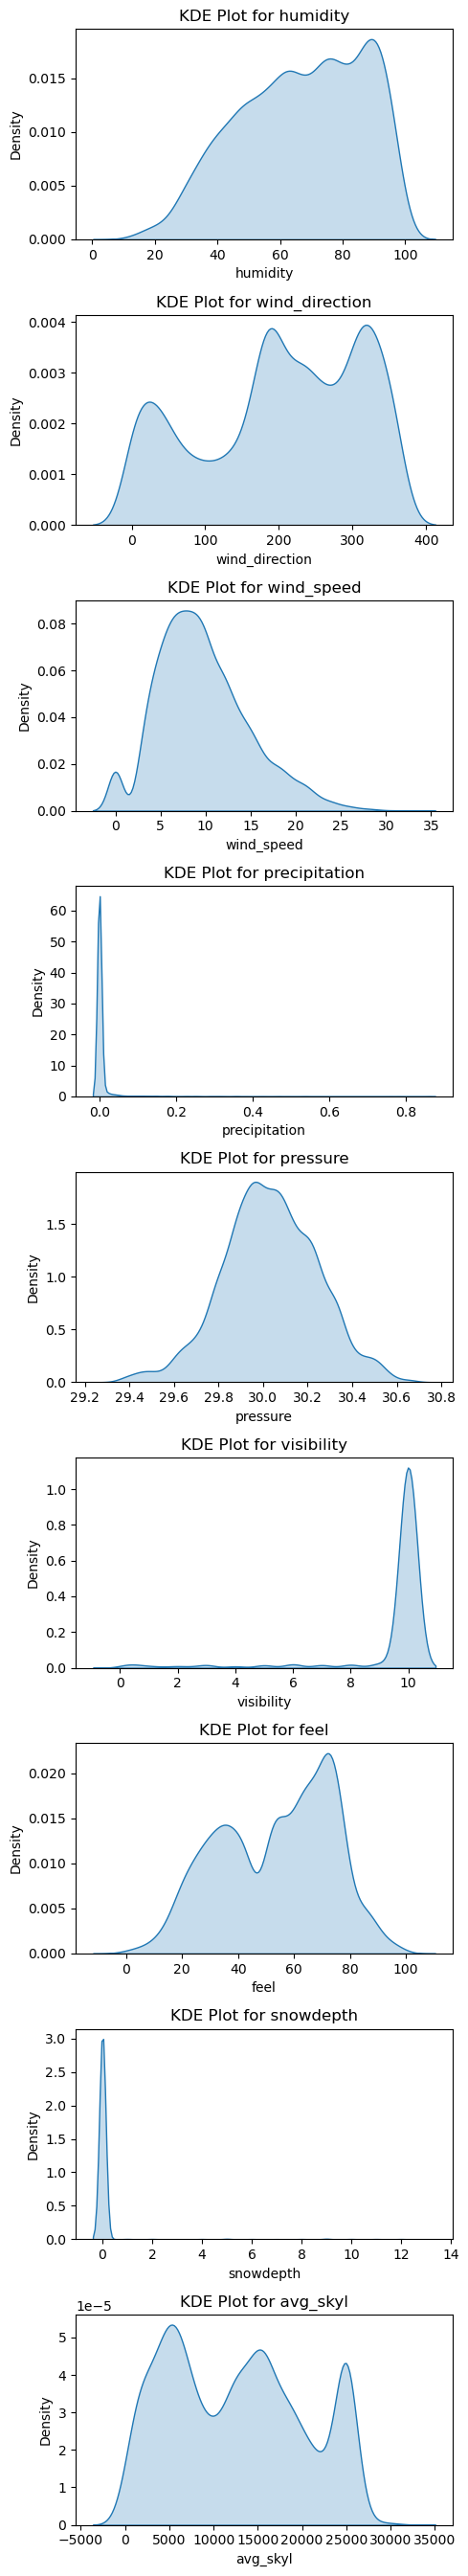

In [76]:
fig, axes = plt.subplots(nrows=num_plots, ncols=1, figsize=(5, 3*num_plots))

# Loop through numeric columns and create KDE plots
for i, col in enumerate(float_cols):
    sns.kdeplot(data=weather, x=col, ax=axes[i], fill=True)
    axes[i].set_title(f'KDE Plot for {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Density')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()

From the above analysis we can clearly see that **precipitation, visibility, snowdepth** are highly skewed.

In [77]:
# precipitation
boxcox_transformed_data, _ = boxcox(weather['precipitation']+1)

In [78]:
pd.DataFrame(boxcox_transformed_data).skew()

0    3.068052
dtype: float64

In [79]:
# visibility
np.exp(weather['visibility']).skew()

-2.458098826610499

In [80]:
# snowdepth
boxcox_transformed_data, _ = boxcox(weather['snowdepth']+1)

In [81]:
pd.DataFrame(boxcox_transformed_data).skew()

0    9.499118
dtype: float64

**precipitation**, **visibility** and **snowdepth** are still highly skewed

In [82]:
# precipitation

In [83]:
weather[weather['precipitation']>0]['precipitation'].describe()

count    723.000000
mean       0.065740
std        0.100623
min        0.010000
25%        0.010000
50%        0.030000
75%        0.070000
max        0.860000
Name: precipitation, dtype: float64

Classifying rain according to BARANI DESIGN Technologies 

article: https://www.baranidesign.com/faq-articles/2020/1/19/rain-rate-intensity-classification

In [84]:
# {0: No rain, 1: light rain, 2: moderate rain, 3: heavy rain}
def condition(x):
    if x==0:
        return 0
    if x<=0.1:
        return 1
    if x<=0.3:
        return 2
    return 3

In [85]:
weather['precipitation'] = weather['precipitation'].apply(condition)

In [86]:
# visibility

In [87]:
X = np.array(weather[weather['visibility']<10]['visibility'])
X = X.reshape(-1, 1)

In [88]:
est = KBinsDiscretizer(n_bins=2, encode='ordinal', strategy='quantile', subsample=None)
est.fit(X)

KBinsDiscretizer(encode='ordinal', n_bins=2, subsample=None)

In [89]:
est.bin_edges_

array([array([0., 5., 9.])], dtype=object)

In [90]:
weather['visibility'].value_counts()

visibility
10.00    7731
9.00      149
6.00      132
8.00      116
7.00      102
3.00       98
5.00       96
0.50       58
0.25       55
4.00       54
2.00       49
1.00       41
2.50       24
1.50       23
0.75       13
0.12        9
0.06        5
0.00        3
1.25        2
Name: count, dtype: int64

In [91]:
weather['visibility'] = weather['visibility'].apply(lambda x: 2 if x==10 else (1 if x>6 else 0))

In [92]:
weather['visibility'].value_counts()

visibility
2    7731
0     662
1     367
Name: count, dtype: int64

In [93]:
# snowdepth

In [94]:
weather[weather['snowdepth']>0]['snowdepth'].describe()

count    94.000000
mean      6.787234
std       3.441906
min       1.000000
25%       4.250000
50%       7.000000
75%       9.000000
max      13.000000
Name: snowdepth, dtype: float64

In [95]:
X = np.array(weather[weather['snowdepth']>0]['snowdepth'])
X = X.reshape(-1, 1)

In [96]:
est = KBinsDiscretizer(n_bins=2, encode='ordinal', strategy='quantile', subsample=None)
est.fit(X)

KBinsDiscretizer(encode='ordinal', n_bins=2, subsample=None)

In [97]:
est.bin_edges_

array([array([ 1.,  7., 13.])], dtype=object)

In [98]:
weather['snowdepth'] = weather['snowdepth'].apply(lambda x: 0 if x==0 else (1 if x<7 else 2))

### 2.1.3 Boxplot

In [99]:
weather[float_cols].kurt()

humidity           -0.827130
wind_direction     -0.983497
wind_speed          0.515719
precipitation      20.540255
pressure            0.104529
visibility          5.758516
feel               -0.915045
snowdepth         120.230756
avg_skyl           -1.141274
dtype: float64

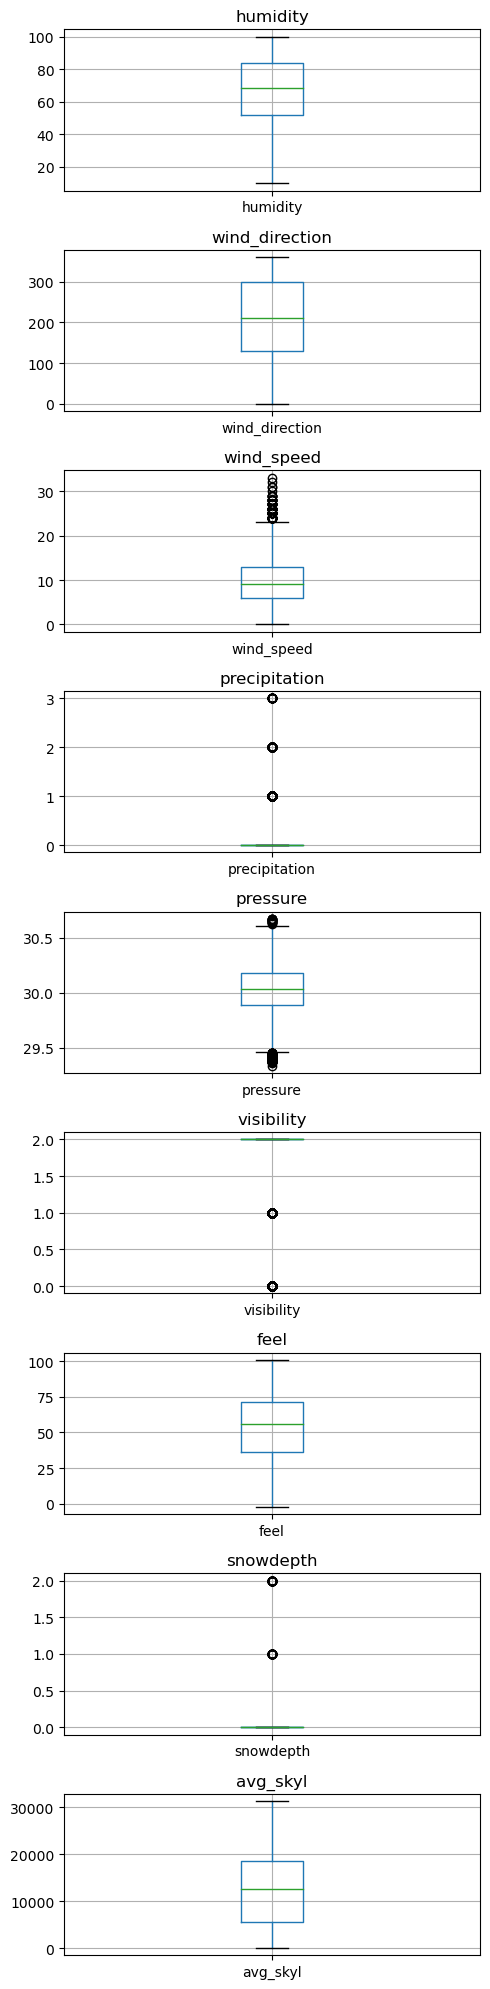

In [100]:
fig, axes = plt.subplots(nrows=len(float_cols), figsize=(5, 20))

for i, col in enumerate(float_cols):
    weather.boxplot(column=col, ax=axes[i])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

**windspeed** and **pressure** have some outliers but they represent extreme climate conditions which affect the weather.

# 3. Feature engineering

## 3.1 Categorical data

Creating dummies of **weather_codes** 

In [101]:
codes = list(weather['weather_codes'])
str_codes = " ".join(codes)
str_codes = str_codes.replace("-",'').replace("+",'')
codes = str_codes.split(" ")

In [102]:
codes_dict = dict(Counter(codes))
codes_dict = dict(sorted(codes_dict.items(), key=lambda item: item[1], reverse=True))

In [103]:
codes_dict

{'CLR': 7232,
 'RA': 840,
 'BR': 730,
 'SN': 133,
 'DZ': 82,
 'TSRA': 47,
 'HZ': 42,
 'FG': 37,
 'FZDZ': 18,
 'VCTS': 13,
 'TS': 11,
 'BLSN': 10,
 'RASN': 9,
 'MIFG': 8,
 'SNPL': 7,
 'SNRA': 6,
 'FZRA': 6,
 'FZFG': 4,
 'FZRAPL': 4,
 'VCFG': 3,
 'PLSN': 1,
 'FZDZSN': 1}

most common weather conditions

**CLR**: Clear sky

**BR**: Mist

**RA** (Rain) Appears in: RA, TSRA, SNRA, FZRA, FZRAPL, RASN

**SN** (Snow) Appears in: SN, BLSN, SNPL, RASN, FZDZSN, PLSN, FZRASN, SNRA

**DZ** (Drizzle) Appears in: DZ, FZDZ, FZDZSN

**TS** (Thunderstorm) Appears in: TS, TSRA, VCTS

**FG** (Fog) Appears in: FG, FZFG, VCFG, MIFG

**FZ** (Freezing) Appearsn in: FZDZ, FZFG, FZRA, FZDZSN, FZRAPL

In [104]:
common_conditions = {
    'RA': ['RA', 'TSRA', 'SNRA', 'FZRA', 'FZRAPL', 'RASN'],
    'SN': ['SN', 'BLSN', 'SNPL', 'RASN', 'FZDZSN', 'PLSN', 'SNRA'],
    'DZ': ['DZ', 'FZDZ', 'FZDZSN'],
    'TS': ['TS', 'TSRA', 'FZDZ'],
    'FG': ['FG', 'FZFG', 'VCFG', 'MIFG'],
    'FZ': ['FZDZ', 'FZFG', 'FZRA', 'FZDZSN', 'FZRAPL'],
    'CLR': ['CLR'],
    'BR': ['BR']
}

In [105]:
for key, value in common_conditions.items():
    addition = 0
    for v in value:
        addition += codes_dict[v]
    print(f"{key} : {addition}")

RA : 912
SN : 167
DZ : 101
TS : 76
FG : 52
FZ : 33
CLR : 7232
BR : 730


In [106]:
weather['weather_codes_list'] = weather['weather_codes'].str.replace("+",'').str.replace("-",'').str.split()

In [107]:
dummy_df = pd.get_dummies(weather['weather_codes_list'].apply(pd.Series).stack())

In [108]:
dummy_df.head(3)

,,BLSN,BR,CLR,DZ,FG,FZDZ,FZDZSN,FZFG,FZRA,FZRAPL,...,PLSN,RA,RASN,SN,SNPL,SNRA,TS,TSRA,VCFG,VCTS
0,0,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,0,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,0,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [109]:
dummy_df.index.names = ['index1', 'index2']

In [110]:
dummy_df = dummy_df.groupby(['index1']).sum()

In [111]:
for key, value in common_conditions.items():
    dummy_df[key] = dummy_df[value].sum(axis=1)

In [112]:
dummy_df[common_conditions.keys()].sum()

RA      912
SN      167
DZ      101
TS       76
FG       52
FZ       33
CLR    7232
BR      730
dtype: int64

In [113]:
dummy_df[common_conditions.keys()].max()

RA     1
SN     2
DZ     1
TS     1
FG     1
FZ     1
CLR    1
BR     1
dtype: int64

In [114]:
dummy_df[dummy_df['SN']>1].index

Index([758, 759, 760, 761, 762, 763, 764, 765, 766, 767], dtype='int64', name='index1')

In [115]:
weather['weather_codes_list'].iloc[758:768]

758    [SN, BLSN, FZFG]
759    [SN, BLSN, FZFG]
760      [SN, BLSN, BR]
761    [SN, BLSN, FZFG]
762    [SNPL, BLSN, BR]
763      [SN, BLSN, BR]
764    [SNPL, BLSN, BR]
765    [SNPL, BLSN, BR]
766    [SNPL, BLSN, BR]
767    [SNPL, BLSN, BR]
Name: weather_codes_list, dtype: object

BLSN and SN both have snow therefore we have count more than one in our dummy columns dataframe

In [116]:
dummy_df = dummy_df.replace(2,1)

In [117]:
dummy_df[common_conditions.keys()].sum()

RA      912
SN      157
DZ      101
TS       76
FG       52
FZ       33
CLR    7232
BR      730
dtype: int64

In [118]:
weather = pd.concat([weather, dummy_df[common_conditions.keys()]], axis=1)

In [119]:
weather = weather.drop(columns=['weather_codes', 'weather_codes_list'])

## 3.2 Numerical data

Why **wind_direction** is imp? 

The direction of the wind helps to determine the climate of a region. The wind coming from the humid region brings cool air while that from the dry region would bring hot air. 

Binning **wind_direction** to avoid overfitting

In [120]:
weather.wind_direction.unique()

array([320., 350., 340., 360.,  30.,  40.,  20.,  50., 120.,  70.,  90.,
        80.,  60.,  10., 300., 330., 290., 260., 250., 270., 280., 310.,
         0., 210., 230., 220., 240., 190., 200., 110., 100., 170., 150.,
       140., 160., 180., 130.])

In [121]:
def bin_wind_direction(angle):
    directions = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']
    angle = (angle % 360 + 360) % 360

    index = round(angle / 45) % 8
    return directions[index]

In [122]:
weather['wind_direction'] = weather['wind_direction'].apply(bin_wind_direction)

In [123]:
weather['wind_direction'].value_counts()

wind_direction
S     1645
N     1590
NW    1481
W     1127
SW    1094
NE     777
E      549
SE     497
Name: count, dtype: int64

# 4 Remaining analysis

##### Dealing with null values in skyc2 and skyc3

In [124]:
weather[['skyc2', 'skyc3']].isnull().sum()

skyc2    1483
skyc3    4092
dtype: int64

***Note:*** _Tried using ML models but accuracy and correlation of skyc is low with other variables_

In [125]:
weather[['skyc2', 'skyc3']] = weather[['skyc2', 'skyc3']].fillna('missing')

In [130]:
weather = weather.set_index('timestamp')

In [131]:
weather.sample(5)

,humidity,wind_direction,wind_speed,precipitation,pressure,visibility,skyc1,skyc2,skyc3,feel,...,month,avg_skyl,RA,SN,DZ,TS,FG,FZ,CLR,BR
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-06-14 18:51:00,73.22,S,11.0,0,29.83,2,FEW,SCT,BKN,71.10,...,6,4733.333333,0,0,0,0,0,0,1,0
2021-06-16 23:51:00,28.25,W,10.0,0,29.87,2,FEW,FEW,missing,73.90,...,6,16750.000000,0,0,0,0,0,0,1,0
2021-01-26 02:51:00,44.89,N,8.0,0,30.10,2,OVC,OVC,missing,25.47,...,1,18500.000000,0,0,0,0,0,0,1,0
2021-05-03 19:51:00,59.98,SE,9.0,0,29.83,2,BKN,OVC,OVC,63.00,...,5,9833.333333,0,0,0,0,0,0,1,0
2021-11-17 14:51:00,51.81,SE,7.0,0,30.34,2,FEW,SCT,BKN,51.10,...,11,13833.333333,0,0,0,0,0,0,1,0


In [132]:
# weather.to_csv(f"{path}/dataset/weather_processed.csv")